This notebook reproduces 

> **Fig 6**: Dependence of the relative energies of all $n=2$ eigenstates in Ps on electric-field strength (a) in the absence of a magnetic field and (b) in a parallel magnetic field of B=130 G...

from the article

> #### Positronium decay from $n = 2$ states in electric and magnetic fields
>
> A. M. Alonso, B. S. Cooper, A. Deller, S. D. Hogan, and D. B. Cassidy.
>
> *Phys. Rev. A*, **93**, 012506 (2016) [DOI:10.1103/PhysRevA.93.012506](https://dx.doi.org/10.1103/PhysRevA.93.012506)

In [1]:
# packages
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pyps import State, Basis, Hamiltonian
from pyps.constants import En_h, h, c, e, a0

# https://github.com/ad3ller/Stark-map-tools
from smtools import sm_sort, lc_cmap

In [2]:
# construct matrix
H = Hamiltonian(Basis(range(1, 4)), sparse_format="array")
print(f"number of basis states: {H.basis.num_states}")

number of basis states: 56


In [3]:
# calculate Stark map
Efield = np.linspace(0, 3000, 1000)  # V / cm
Bfield = 0.013  # T
triplets = list(H.basis.argwhere(lambda x: x.S == 1))

sm00, amp00 = H.stark_map(
    Efield * 100, elements=triplets, units="Hz", tqdm_kw={"disable": True}
)
sm13, amp13 = H.stark_map(
    Efield * 100, Bfield, elements=triplets, units="Hz", tqdm_kw={"disable": True}
)

# sorting
sm00, amp00 = sm_sort(sm00, amp00)
sm13, amp13 = sm_sort(sm13, amp13)

# ensure 0 < amp0 < 1
amp00 = np.clip(amp00, 0, 1)
amp13 = np.clip(amp13, 0, 1)

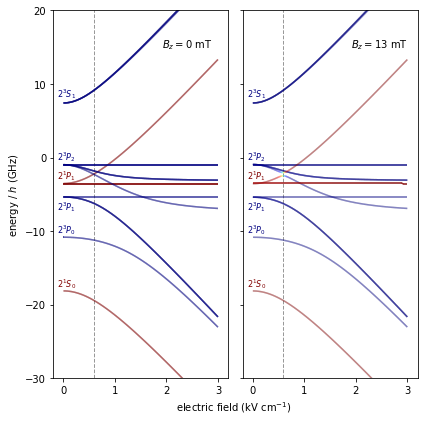

In [4]:
cmap = cm.jet_r
# plot
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 6))

# n=2 Bohr model energy offset
y_offset = En_h / 16.0 / h
for ix in H.basis.argwhere(lambda x: x.n == 2):
    cs = cmap(amp00[:, ix], alpha=0.8)
    lc = lc_cmap(1e-3 * Efield, 1e-9 * (sm00[:, ix] + y_offset), cs)
    lc.set_linewidth(1.5)
    ax[0].add_collection(lc)

    cs = cmap(amp13[:, ix], alpha=0.6)
    lc = lc_cmap(1e-3 * Efield, 1e-9 * (sm13[:, ix] + y_offset), cs)
    lc.set_linewidth(1.5)
    ax[1].add_collection(lc)

# avoided crossing
xline = 0.585
ax[0].axvline(xline, ls="--", c="k", lw=1, alpha=0.4, zorder=-20)
ax[1].axvline(xline, ls="--", c="k", lw=1, alpha=0.4, zorder=-20)

# labels
y_adjust = [0.6, 0.6, -1.7, 0.6, 0.7, 0.8]
for state, adjust in zip(H.basis.where(lambda x: x.n == 2 and x.MJ == 0), y_adjust):
    c = cmap(float(state.S))
    lbl = state.tex(show_MJ=False)
    en = 1e-9 * (state.energy(units="Hz") + y_offset)
    ax[0].annotate(lbl, [-0.12, en + adjust], size=8, color=c)
    ax[1].annotate(lbl, [-0.12, en + adjust], size=8, color=c)

# format
ax[0].set_ylabel("energy / $h$ (GHz)")
ax[0].set_xlim(-0.2, 3.2)
ax[0].set_ylim(-30, 20)

ax[0].text(0.62, 0.9, r"$B_z = 0$ mT", transform=ax[0].transAxes)
ax[1].text(0.62, 0.9, r"$B_z = %d$ mT" % (Bfield * 1e3), transform=ax[1].transAxes)
# shared x-label
plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.text(0.55, 0.04, "electric field (kV cm$^{-1}$)", ha="center")

# output
fileout = os.path.join("../images/stark_n2.png")
plt.savefig(fileout, dpi=150)
plt.show()

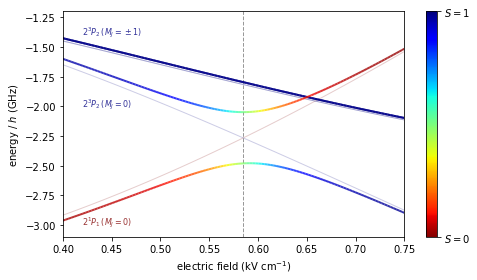

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))

# plot
for ix in H.basis.argwhere(lambda x: x.n == 2):
    cs = cmap(amp00[:, ix], alpha=0.8)
    lc = lc_cmap(1e-3 * Efield, 1e-9 * (sm00[:, ix] + y_offset), cs)
    lc.set_linewidth(1)
    lc.set_alpha(0.2)
    lc.set_zorder(-10)
    ax.add_collection(lc)

    cs = cmap(amp13[:, ix], alpha=0.8)
    lc = lc_cmap(1e-3 * Efield, 1e-9 * (sm13[:, ix] + y_offset), cs)
    lc.set_linewidth(2)
    ax.add_collection(lc)

# avoided crossing
ax.axvline(xline, ls="--", c="k", lw=1, alpha=0.4, zorder=-20)

# labels
pos = np.argmin(abs(1e-3 * Efield - 0.42))

indx = next(
    H.basis.argwhere(lambda x: x.n == 2 and x.L == 1 and x.S == 0 and x.MJ == 0)
)
lbl = H.basis[indx].tex()
c = cmap(amp00[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -3.0], size=8, color=c)

indx = next(
    H.basis.argwhere(
        lambda x: x.n == 2 and x.L == 1 and x.S == 1 and x.J == 2 and x.MJ == 0
    )
)
lbl = H.basis[indx].tex()
c = cmap(amp00[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -2.0], size=8, color=c)

indx = next(
    H.basis.argwhere(
        lambda x: x.n == 2 and x.L == 1 and x.S == 1 and x.J == 2 and x.MJ == 1
    )
)
lbl = H.basis[indx].tex().replace("= 1", r"= \pm 1")
c = cmap(amp00[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -1.4], size=8, color=c)

# colorbar
smcb = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
smcb._A = []
cbar = plt.colorbar(smcb, ticks=[0, 1])
cbar.ax.set_yticklabels([r"$S = 0$", r"$S = 1$"])

# format
ax.set_ylabel("energy / $h$ (GHz)")
ax.set_xlabel("electric field (kV cm$^{-1}$)")
ax.set_ylim(-3.1, -1.2)
ax.set_xlim(0.4, 0.75)

plt.tight_layout()
# output
fileout = os.path.join("../images/stark_n2_zoom.png")
plt.savefig(fileout, dpi=150)
plt.show()